## Import librairies 

In [ ]:
%tensorflow_version 2.x
import json
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import sklearn.preprocessing as sk
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Read Data 

In [ ]:
# endpoint = 'https://min-api.cryptocompare.com/data/histoday'
# res = requests.get(endpoint + '?fsym=BTC&tsym=EUR&limit=500')
# data = pd.read_csv("/content/BTC-USD Historical Data_TEST.csv",delimiter=";")
data = pd.read_csv("/content/BTC-USD Historical Data.csv")
data = data.set_index('Date')
data.head()

# définition de la colonne cible
target = 'Close'

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


## Define train test split

In [ ]:
def train_test_split(df, test_size):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(data, test_size=0.2)

## Visualise train test split with line plot

In [ ]:
def line(y1, y2, label1=None, label2=None, title='', lw=2):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=y1,
                    mode='lines',
                    name='training'))
    fig.add_trace(go.Scatter(x=test.index, y=y2,
                    mode='lines',
                    name='test'))
    fig.show()
line(train[target], test[target], 'training', 'test', title='')

In [ ]:
# def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
#     fig, ax = plt.subplots(1, figsize=(15, 7))
#     ax.plot(line1, label=label1, linewidth=lw)
#     ax.plot(line2, label=label2, linewidth=lw)
    
#     ax.set_xlabel('Date', fontsize=14)
#     ax.set_ylabel('price [USD]', fontsize=14)
#     ax.set_title(title, fontsize=16)
#     ax.legend(loc='best', fontsize=16)
# #   # Tell matplotlib to interpret the x-axis values as dates
# #     ax.xaxis_date()

# # # Make space for and rotate the x-axis tick labels
# #     fig.autofmt_xdate()
    
# line_plot(train[target_col], test[target_col], 'training', 'test', title='')

## Preprocessing 

### Normalize with first line

This method normalise data by dividing the dataset with the first line of the dataset 

In [ ]:
def normalize_withfirstline(df):
    return df / df.iloc[0] - 1

In [ ]:
data.shape

(1791, 6)

### Normalize with min max : 0< value<1

In [ ]:
# def normalize_withminmax(df):
#     return (df - df.min()) / (data.max() - df.min())

### shifting window and normalize data to train 

Example with a thousand words:
Let me paint the picture; to help explain the idea of a shifting window prediction.

For each train set (e.g. from t=0 to t=5 in red - train set 1), you want to predict the following H time steps (corresponding to t=6 in orange - test set 1). In this, your horizon is simply one i.e. H=1.

Basic sketch of a rolling out-of-sample forecast

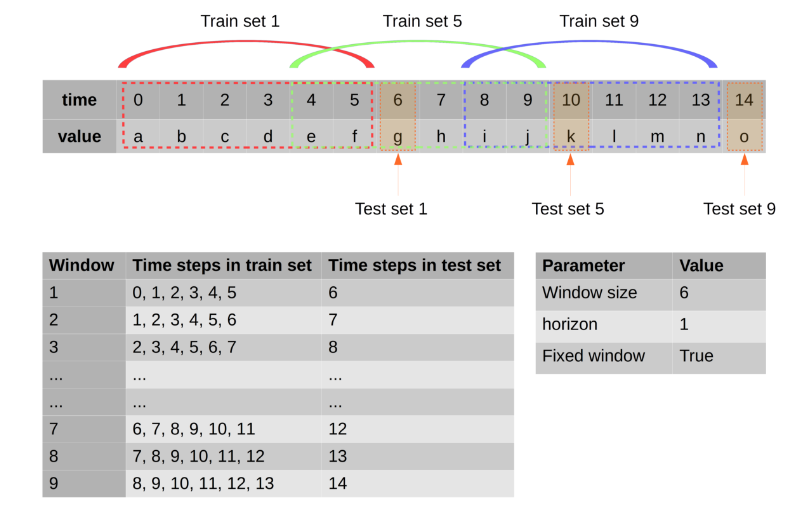
From what I understand, you would like to predict the next 10 days, meaning you need H=10.

In [ ]:
def timesteps_data(df, timesteps_len, first_line=True):
    sample = []
    for i in range(len(df) - timesteps_len):
        s = df[i: (i + timesteps_len)].copy()
        if first_line:
            s = normalize_withfirstline(s)
        sample.append(s.values)
    return np.array(sample)

In [ ]:
# def timesteps_data_Y(df, timesteps_len, first_line=True):
#     H = 10        #10 days
#     sample = []
#     for i in range(len(df) - timesteps_len + H):
#         s = df[(i+timesteps_len): (i + timesteps_len+H)].copy()
#         if first_line:
#             s = normalize_withfirstline(s)
#         sample.append(s.values)
#     return np.array(sample)

### Prepare data 

In [ ]:
def prepare_data( df,  goal, timesteps_len, test_size, first_line=True):

    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = timesteps_data(train_data, timesteps_len, first_line)
    X_test = timesteps_data(test_data, timesteps_len, first_line)
    y_train = train_data[goal][timesteps_len:].values
    y_test = test_data[goal][timesteps_len:].values
    if first_line:
        y_train = y_train / train_data[goal][:-timesteps_len].values - 1
        y_test = y_test / test_data[goal][:-timesteps_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

## Build LSTM Model

In [ ]:
data['Close'].shape

(1791,)

Dropout is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network. This has the effect of reducing overfitting and improving model performance.

In [ ]:
def LSTM_model(input_data, output_size, neurons, active_function, dropout,
                     loss, optimizer,metrics):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(active_function)) 
    model.compile(loss=loss, optimizer=optimizer,metrics=metrics)
    return model

## Fix parameters to train the model

In [ ]:
#np.random.seed(100)
#Data
timesteps_len = 15
test_size = 0.2


#Model
neurons = 100
batch_size = 64
epochs = 60

#Metrics and loss
loss = 'mse'
metrics='mean_absolute_error'

#Regularization
active_function= 'linear'
dropout = 0.2

#Optimizer
optimizer = 'adam'

## Train the model using parameters

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(data, target, timesteps_len=timesteps_len, test_size=test_size)

In [ ]:
model = LSTM_model(
    X_train, output_size=1, neurons=neurons, dropout=dropout, loss=loss,active_function=active_function,
    optimizer=optimizer,metrics=metrics)

In [ ]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/60
23/23 [==============================] - 3s 21ms/step - loss: 0.0167 - mean_absolute_error: 0.0918
Epoch 2/60
23/23 [==============================] - 0s 20ms/step - loss: 0.0053 - mean_absolute_error: 0.0539
Epoch 3/60
23/23 [==============================] - 0s 21ms/step - loss: 0.0042 - mean_absolute_error: 0.0475
Epoch 4/60
23/23 [==============================] - 0s 20ms/step - loss: 0.0037 - mean_absolute_error: 0.0437
Epoch 5/60
23/23 [==============================] - 0s 21ms/step - loss: 0.0032 - mean_absolute_error: 0.0413
Epoch 6/60
23/23 [==============================] - 0s 21ms/step - loss: 0.0030 - mean_absolute_error: 0.0398
Epoch 7/60
23/23 [==============================] - 1s 22ms/step - loss: 0.0030 - mean_absolute_error: 0.0393
Epoch 8/60
23/23 [==============================] - 1s 22ms/step - loss: 0.0028 - mean_absolute_error: 0.0383
Epoch 9/60
23/23 [==============================] - 1s 22ms/step - loss: 0.0027 - mean_absolute_error: 0.0371
Epoch 10/6

## MAE metrics Result

In [ ]:
y = test[target][timesteps_len:]
yhat = model.predict(X_test).squeeze()
tf.keras.metrics.mean_absolute_error(yhat, y_test)

11/11 [==============================] - 0s 6ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.0229207317769281>

In [ ]:
yhat

array([-5.57625815e-02, -5.21257855e-02, -7.56411031e-02, -4.24513444e-02,
       -3.21882702e-02,  5.77753671e-02,  7.75176510e-02,  2.60782130e-02,
        1.07442355e-02,  8.58156011e-02,  2.65507139e-02, -4.71590199e-02,
       -1.45491986e-02,  4.76384163e-03,  1.54344868e-02,  1.13841891e-02,
       -7.51395430e-03, -5.94267622e-02, -9.47174355e-02, -1.52989835e-01,
       -1.71361104e-01, -1.68259278e-01, -1.69737607e-01, -1.82596564e-01,
       -1.14522360e-01, -5.98736405e-02, -8.72035325e-02, -7.30316639e-02,
       -9.54812989e-02, -9.25995335e-02, -9.05719101e-02, -8.01244453e-02,
       -4.26667891e-02, -4.66804355e-02, -1.14058249e-01, -1.52880952e-01,
       -1.39794037e-01, -1.31376028e-01, -1.39026657e-01, -1.56867474e-01,
       -1.33756384e-01, -1.31561577e-01, -1.23085275e-01, -1.24664068e-01,
       -9.46376398e-02, -8.19957554e-02, -1.03560798e-01, -9.21656713e-02,
        1.23515420e-01,  2.02552035e-01,  1.77515313e-01,  1.99842855e-01,
        1.99548006e-01,  

## Show predictions yhat

In [ ]:
# Find predictions to compare with real values

yhat = test[target].values[:-timesteps_len] * (yhat + 1)
yhat = pd.Series(index=y.index, data=yhat)

## Plot predictions vs actual value of the target

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train[target],
                    mode='lines',
                    name='training set'))
fig.add_trace(go.Scatter(x=test.index,y=test[target],
                    mode='lines',
                    name='test set'))
fig.add_trace(go.Scatter(x=y.index, y=yhat,
                    mode='lines',
                    name='prediction'))
fig.show()

# Predictions on 15 days on new dataset 

In [ ]:
data = pd.read_csv("/content/BTC-USD Historical Data_TEST.csv", delimiter=";")

data = data.set_index('Date')
data.head()

# définition de la colonne cible
target = 'Close'

FileNotFoundError: ignored

## Train Test Split

In [ ]:
train, test = train_test_split(data, test_size=0.2)

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(data, target, timesteps_len=timesteps_len, test_size=test_size)

## Run the model

In [ ]:
model = LSTM_model(
    X_train, output_size=1, neurons=neurons, dropout=dropout, loss=loss,active_function=active_function,
    optimizer=optimizer,metrics=metrics)

In [ ]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

## Predictions

In [ ]:
y = test[target][timesteps_len:]
yhat = model.predict(X_test).squeeze()
tf.keras.metrics.mean_absolute_error(yhat, y_test)

In [ ]:
test[target]

In [ ]:
yhat = test[target].values[:-timesteps_len-1] * (yhat + 1)
yhat = pd.Series(data=yhat)

In [ ]:
yhat

In [ ]:
# yhat.to_csv("yhat_LSTM_pred_1111_3011.csv")

## Plot 15 day predictions

In [ ]:
fig = go.Figure()
# fig.add_trace(go.Scatter(x=train.index,y=train[target],
#                     mode='lines',
#                     name='training set'))
fig.add_trace(go.Scatter(x=test.index,y=test[target],
                    mode='lines',
                    name='test set'))
fig.add_trace(go.Scatter(x=y.index, y=yhat,
                    mode='lines',
                    name='prediction'))
fig.show()